## TensorFlow Deep Neural Network Demo

This notebook is based on the material in https://github.com/samwit/TensorFlowTalks/tree/master/Talk01_introduction_to_TF.
A similar example from Google is found at https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py.

### Import TensorFlow

In [1]:
import tensorflow as tf
tf.__version__
tf.logging.set_verbosity(tf.logging.ERROR)

C:\Users\WF4\Anaconda3\envs\tf18_py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### MNIST Model with Pure TensorFlow

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Import MNIST from TF Examples
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/mnist/", one_hot=True)

# Load data
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


### MNIST Image Tensor X_train

<img src="./images/xtrain_tensor.png" style="width:550px;">
<img src="./images/xtrain_flat.png" style="width:550px;">

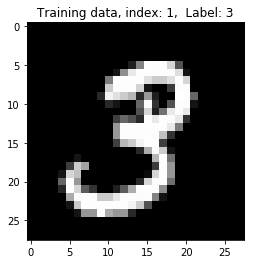

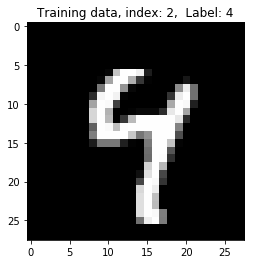

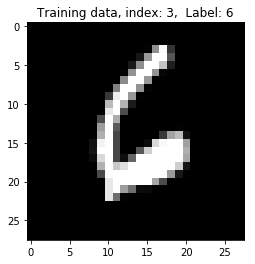

In [5]:
# Method for displaying the number as a picture

def show_digit(index):
    label = Y_train[index].argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = X_train[index].reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.title('Training data, index: %d,  Label: %d' % (index, label))
    plt.imshow(image, cmap='gray')
    plt.show()
    
def show_predicted_digit(image, pred, label):
    # Reshape 784 array into 28x28 image
    image = image.reshape([28,28])
    plt.title('Original Image, Pred: %d,  True Label: %d' %(pred, label))
    plt.imshow(image, cmap='gray')
    plt.show()
    
# Display the first (index 0) training image
show_digit(1)
show_digit(2)
show_digit(3)

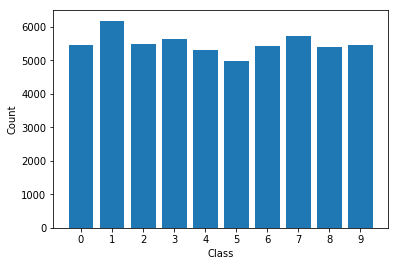

In [7]:
# Show the distribution of classes in MNIST training set

training_labels = np.array(np.where(Y_train==1)[1], dtype='float32')
labels, counts = np.unique(training_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### Batching allows TF to streamline a computation for the processors eg. GPU

In [8]:
# Create a batch of 64 images and their labels
batch_X, batch_Y = mnist.train.next_batch(64)

In [11]:
batch_X.shape

(64, 784)

<img src="images/nn.gif" style="width:500px;">

### Setting up our Network Hyper Parameters

In [12]:
# Training Parameters for basic MNIST
learning_rate = 0.05 
training_epochs = 2
batch_size = 100
display_step = 1  # for how often to print out our results
test_step = 50 # for how often to test our test set
model_path = "./models_mnist/model1.ckpt"


# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28 flattened to be 784)
n_hidden_1 = 384 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_classes = 10 # MNIST classes for prediction(digits 0-9 )
normal_dist_stddev = 0.1 # Standard deviation for random sampling from normal distribution for initialisation

### Define the inputs

In [13]:
# Reset the graph
tf.reset_default_graph()

# tf Graph input
with tf.name_scope('Inputs') as scope:
    x = tf.placeholder(tf.float32, [None, n_input],name='x_input')
    y = tf.placeholder(tf.float32, [None, n_classes],name='labels')

### Create our deep neural network model

In [14]:
# Create model
def multilayer_perceptron(x):
    
    with tf.name_scope('hidden_01') as scope:
        # Hidden layer 01 with RELU activation
        
        #weights and bias tensor
        h1weight = tf.Variable(tf.truncated_normal([n_input, n_hidden_1],stddev=normal_dist_stddev),name='h1_weights')
        h1bias = tf.Variable(tf.truncated_normal([n_hidden_1],stddev=normal_dist_stddev),name='b1_bias')
        
        #hidden layer 01 Ops
        layer_1 = tf.add(tf.matmul(x, h1weight), h1bias,name='Layer1_matmul')  # adding (x•w1) + bias1)
        layer_1 = tf.nn.relu(layer_1, name='Layer1_Relu') #activation Relu passes anything above 0 and blocks negative
        
        #tensorboard histograms for layer 01
        tf.summary.histogram('weights_h1',h1weight)
        tf.summary.histogram('bias_h1',h1bias)
        
    with tf.name_scope('hidden_02') as scope:
        # Hidden layer 02 with RELU activation
        h2weights = tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],stddev=normal_dist_stddev),name='h2_weights')
        h2bias = tf.Variable(tf.truncated_normal([n_hidden_2],stddev=normal_dist_stddev),name='b2_bias')
        
        layer_2 = tf.add(tf.matmul(layer_1, h2weights), h2bias,name='Layer2_add')
        layer_2 = tf.nn.relu(layer_2, name='Layer2_Relu')
        #tensorboard histograms
        tf.summary.histogram('weights_h2',h2weights)
        tf.summary.histogram('bias_h2',h2bias)
        
    with tf.name_scope('output_layer') as scope:
        # Logits layer with linear activation
        output_weights = tf.Variable(tf.truncated_normal([n_hidden_2, n_classes],stddev=normal_dist_stddev),name='output_weights')
        output_bias = tf.Variable(tf.truncated_normal([n_classes],stddev=normal_dist_stddev),name='out_bias')
        
        logits_layer = tf.add(tf.matmul(layer_2, output_weights), output_bias,name='logits')

    return logits_layer

### Logits are the unscaled outputs of a neural network

In [15]:
logits = multilayer_perceptron(x)

### Define the loss function, optimizer and outputs

In [16]:
# Define loss and optimizer
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels= y, logits=logits ))   #compute the error against the correct results

with tf.name_scope('train'):    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) # optimizer makes changes to the weights and bias to reduce loss
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    
with tf.name_scope('prediction'):
    pred_label = tf.argmax(logits, 1, name='out_argmax')
    pred_probs = tf.nn.softmax(logits, name='out_softmax')
    pred_prob_top = tf.reduce_max(pred_probs, 1, name='out_softmax_argmax')

In [17]:
# Initializing the variables
init = tf.global_variables_initializer()

# Define and merge performance measures for TensorBoard graphs
tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar("loss", loss)
summary_op = tf.summary.merge_all()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# Session Configuration
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   # don't allow session to take up all the GPU memory

### Run the session

In [18]:
%%time

# Launch the graph
with tf.Session(config=config) as sess:
    # Initialize the variables in the graph
    sess.run(init)
    
    train_writer = tf.summary.FileWriter('./log_mnist_dnn/train', sess.graph)
    test_writer = tf.summary.FileWriter('./log_mnist_dnn/test', sess.graph)
    
    step = 0
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        avg_accuracy = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, acc, summary_train = sess.run([optimizer, loss, accuracy, summary_op], 
                                                feed_dict={x: batch_x, y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch

            # Compute average accuracy
            avg_accuracy += acc / total_batch

            # Increment step
            step += 1

            # Write to file the TensorBoard variables
            train_writer.add_summary(summary_train, step)
            
            if step % test_step == 0:
                # Insert summary of performance measures over whole test set into session
                summary_test = sess.run(summary_op,
                                       feed_dict={x: mnist.test.images, y: mnist.test.labels})
                # Write to file the TensorBoard variables
                test_writer.add_summary(summary_test, step)

        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("Epoch:", "{:}".format(epoch+1), "Loss =", "{:.9f}".format(avg_cost), \
                   "Training Accuracy =", "{:.9f}".format(avg_accuracy) )
                
    train_writer.close()
    test_writer.close()
    
    print ("Optimization Finished!")
    
    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print ("Model saved to: %s" % save_path)

Epoch: 1 Loss = 0.531686704 Training Accuracy = 0.879727273
Epoch: 2 Loss = 0.353804464 Training Accuracy = 0.914090912
Optimization Finished!
Model saved to: ./models_mnist/model1.ckpt
Wall time: 19.2 s


Start TensorBoard in a separate terminal by copying the line below.

### Testing against our Test Data

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    
    # Restore model weights from previously saved model
    load_path = saver.restore(sess, model_path)
    print ("Model restored from file: %s" % model_path)
    
    test_accuracy, test_loss = sess.run([accuracy, loss],
                               feed_dict={x: mnist.test.images, y: mnist.test.labels})
    
    
    print ("Test Loss =", "{:.9f}".format(test_loss), \
            "Test Accuracy =", "{:.9f}".format(test_accuracy) )

In [ ]:
def predict_image_from_test(imageNumber):
    imvalue = X_test[imageNumber]
    trueValue = np.argmax(Y_test[imageNumber],0)
    with tf.Session() as sess:
        sess.run(init)
        # Restore model weights from previously saved model
        load_path = saver.restore(sess, model_path)
        # Predict model 1 image batch size = 1
        predicted_label, predicted_probability = sess.run([pred_label, pred_prob_top], feed_dict={x: [imvalue]})
        #show image and result
        print("Prediction Probability =", "{:.9f}".format(predicted_probability[0]))
        show_predicted_digit(imvalue, predicted_label, trueValue)

In [ ]:
predict_image_from_test(1000)